# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

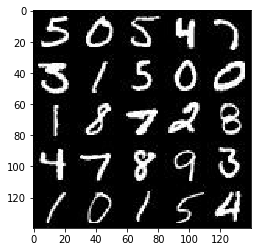

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

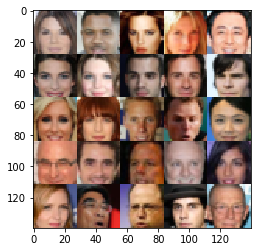

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    # TODO: Implement Function

    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(input, alpha=0.2, name='leaky_relu'):
    return tf.maximum(input, input * alpha, name=name)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        keep_prob = 0.7
        def conv2d(inp, filters):
            return tf.layers.conv2d(inp,
                filters=filters, kernel_size=5, strides=2,
                padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())

        # images is 28x28xN
        
        # 14x14x128
        c1 = conv2d(images, 128)
        c1 = leaky_relu(c1, alpha, name='c1_relu')
        c1 = tf.nn.dropout(c1, keep_prob)
        
        # 7x7x256
        c2 = conv2d(c1, 256)
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = leaky_relu(c2, alpha)
        c2 = tf.nn.dropout(c2, keep_prob)
        
        # 4x4x512
        c3 = conv2d(c2, 512)
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = leaky_relu(c3, alpha)
        c3 = tf.nn.dropout(c3, keep_prob)
        c3.set_shape((None, 4, 4, 512))

        c3 = tf.reshape(c3, (-1, 4*4*512))
        logits = tf.layers.dense(c3, 1)
        out = tf.nn.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, output_dim, training=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not training):
        alpha = 0.2
        keep_prob = 0.7
        def conv_t(inp, filters, strides):
            return tf.layers.conv2d_transpose(inp,
                filters=filters, kernel_size=5, strides=strides,
                padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())

        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=training)
        h1 = leaky_relu(h1, alpha)
        h1 = tf.nn.dropout(h1, keep_prob)
        
        # 14 x 14 x 256
        c1 = conv_t(h1, 256, 2)
        c1 = tf.layers.batch_normalization(c1, training=training)
        c1 = leaky_relu(c1, alpha)
        c1 = tf.nn.dropout(c1, keep_prob)
        
        # 28 x 28 x 128
        c2 = conv_t(c1, 128, 2)
        c2 = tf.layers.batch_normalization(c2, training=training)
        c2 = leaky_relu(c2, alpha)
        c2 = tf.nn.dropout(c2, keep_prob)

        # 28 x 28 x 64
        c3 = conv_t(c2, 64, 1)
        c3 = tf.layers.batch_normalization(c3, training=training)
        c3 = leaky_relu(c3, alpha)
        c3 = tf.nn.dropout(c3, keep_prob)

        # 28 x 28 x output_dim
        c4 = conv_t(c3, output_dim, 1)
        c4.set_shape((None, 28, 28, output_dim))
        logits = c4

        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)

    d_labels_real = tf.ones_like(d_logits_real) * 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real), name='d_loss_real')
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)), name='d_loss_fake')
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)), name='g_loss')

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every = 10
    show_every = 100
    show_size = 25
        
    _, w, h, c = data_shape
    input_real, input_z, lr = model_inputs(w, h, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    saver = tf.train.Saver()
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # from [-0.5,0.5] to [-1,1]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_size, input_z, c, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.4137... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 4.6827... Generator Loss: 0.1808
Epoch 1/2... Discriminator Loss: 2.3930... Generator Loss: 0.3140
Epoch 1/2... Discriminator Loss: 2.4101... Generator Loss: 0.2964
Epoch 1/2... Discriminator Loss: 1.6321... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 1.4838... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 2.1864
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 1.9075... Generator Loss: 0.4139
Epoch 1/2... Discriminator Loss: 1.6016... Generator Loss: 0.9889


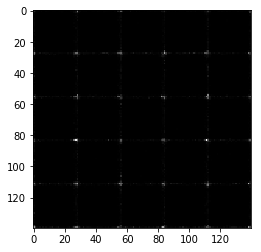

Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 1.5170
Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 1.0190
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 1.3569
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 1.0118
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 1.3553


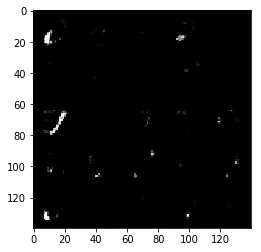

Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.4288
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 1.8668
Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.7041


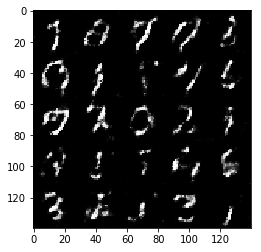

Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 1.9642
Epoch 1/2... Discriminator Loss: 1.6694... Generator Loss: 2.5458
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.7902
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 1.5952... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.2537
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.7499
Epoch 1/2... Discriminator Loss: 1.8596... Generator Loss: 0.4492


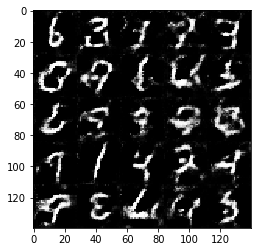

Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 1.0845
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 1.5278
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.6481
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.6046
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.6955
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 1.4944... Generator Loss: 1.0335


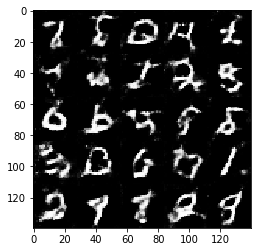

Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.8652
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 1.4563
Epoch 1/2... Discriminator Loss: 1.6237... Generator Loss: 0.4885
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.8158
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 1.1403
Epoch 1/2... Discriminator Loss: 1.5002... Generator Loss: 1.8794
Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 0.5497
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.7301
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.9965


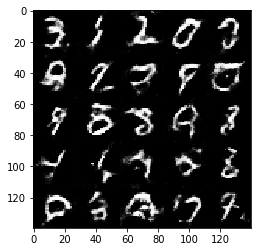

Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 1.5940... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 1.9971
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.8264
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 1.6884
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 0.4638
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 1.1519
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 1.2384


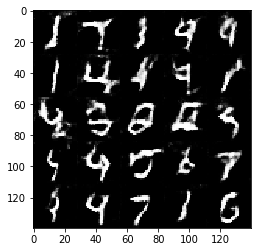

Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 1.2834
Epoch 1/2... Discriminator Loss: 1.6305... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 1.2019
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.5642
Epoch 1/2... Discriminator Loss: 1.7716... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 1.0395
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 1.0978


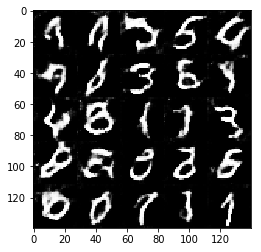

Epoch 1/2... Discriminator Loss: 1.6257... Generator Loss: 0.4769
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 1.5302
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 1.5393... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 1.4780
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.9987


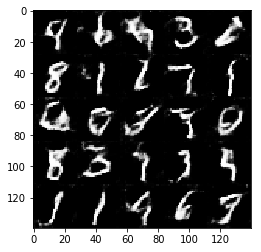

Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 1.3674
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 1.1034
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 1.0957
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 1.1264
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 1.1829
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 1.3062
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.9827


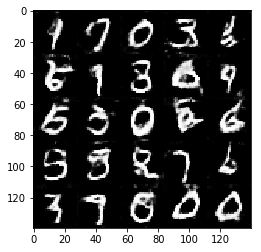

Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 1.3864
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.8606
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 1.1758
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.4693
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.9139
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 1.6757


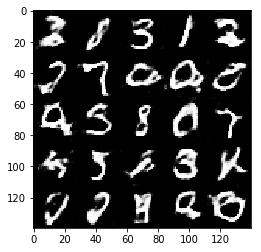

Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.6111
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 1.4970
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 1.1633
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 1.3033
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 1.0691
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.1458


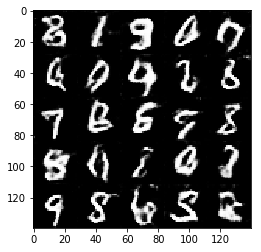

Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 1.0633
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 1.7378
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 1.8180
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 1.6185


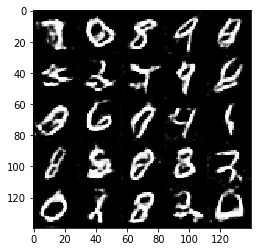

Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.0850
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.9546
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 1.3867
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 1.4233


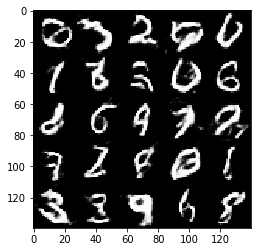

Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.8745
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 1.8185
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 1.7129
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.7068
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 1.7036
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.7612


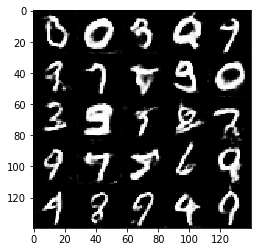

Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 1.0628
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 1.3462
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 1.9090
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 1.2104
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.9235


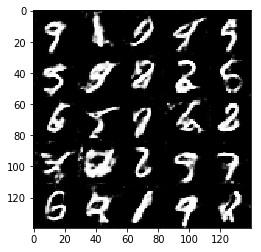

Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 1.2207
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 1.1161
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 1.5106
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.6078
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 0.9285
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.0928
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.2734


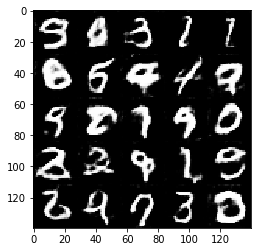

Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 1.1953
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 1.9806
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 1.6898
Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 1.4096
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.1255
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.8220
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.2196
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 2.1376
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.2649... Generator Loss: 0.6766


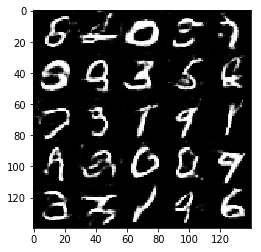

Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 1.2960
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 1.3846
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.8188
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 1.9336
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.2265


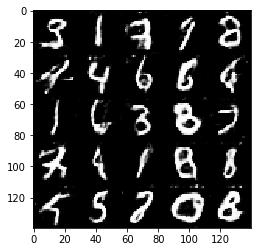

Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 0.9588
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.8296
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 1.4340
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 1.7748
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.7397


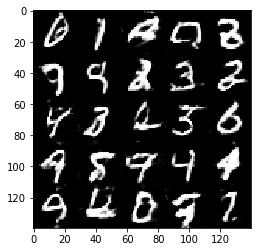

Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.5902... Generator Loss: 0.4674
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 1.8425
Epoch 2/2... Discriminator Loss: 1.2134... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 1.7906


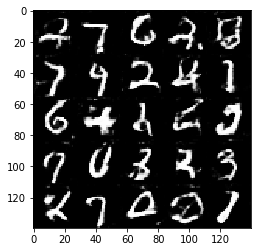

Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.4269
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 1.6897
Epoch 2/2... Discriminator Loss: 1.1155... Generator Loss: 1.5915
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 1.9223
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.4313
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.5828
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 2.0312
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 1.3536


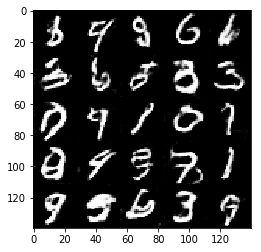

Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.9647
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 1.4160... Generator Loss: 0.4648
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 1.4166
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.7666


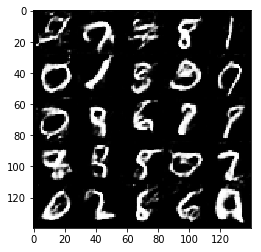

Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.3457
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 1.5399
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.4841
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 1.6735
Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 1.0625
Epoch 2/2... Discriminator Loss: 1.0870... Generator Loss: 1.7820
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 1.2213


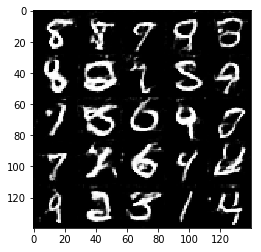

Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 1.4259
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 1.0177
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.6035
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.2378
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 1.0333
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 1.1797


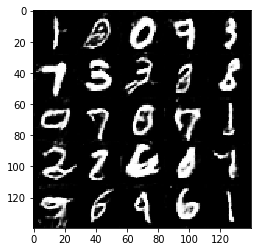

Epoch 2/2... Discriminator Loss: 1.5352... Generator Loss: 2.1312
Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.9589
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 1.5669
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 1.5363
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 1.0738


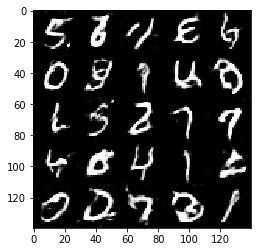

Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 1.5750
Epoch 2/2... Discriminator Loss: 0.9970... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 1.5272... Generator Loss: 0.6125
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 1.5529
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 1.5314... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 1.4553


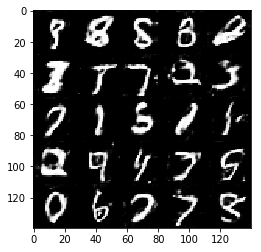

Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 2.2499
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 1.5405
Epoch 2/2... Discriminator Loss: 1.1055... Generator Loss: 1.6944
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 1.3207
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 1.2184


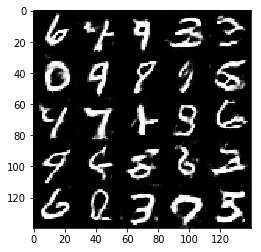

Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 1.4854
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 1.7111
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.0864
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.1512... Generator Loss: 1.5512
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 1.0269
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 1.7027
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 1.0261
Epoch 2/2... Discriminator Loss: 1.1125... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 1.0930


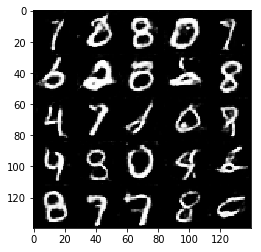

Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 1.1990
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 1.9445
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 1.1829
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 1.1653... Generator Loss: 1.0660
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 0.9795... Generator Loss: 1.5216
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 1.9268
Epoch 2/2... Discriminator Loss: 1.4864... Generator Loss: 0.7493
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 1.2714


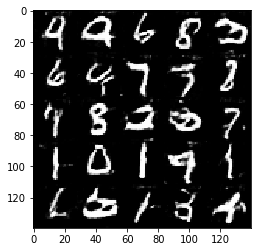

Epoch 2/2... Discriminator Loss: 1.6180... Generator Loss: 0.3960
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 1.8106
Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 1.1505
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 1.3469
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 1.3541
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 1.0084


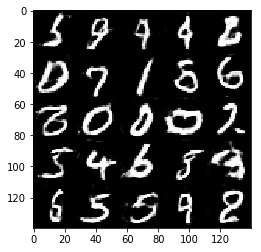

Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 1.8351
Epoch 2/2... Discriminator Loss: 1.6424... Generator Loss: 2.5308
Epoch 2/2... Discriminator Loss: 1.4838... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 1.8499
Epoch 2/2... Discriminator Loss: 1.1248... Generator Loss: 0.8633
Epoch 2/2... Discriminator Loss: 0.9120... Generator Loss: 1.8097
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 1.4555
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 1.3773
Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.6473


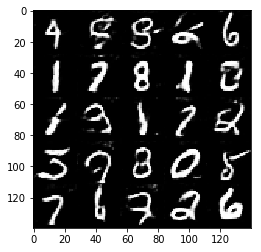

Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.6689
Epoch 2/2... Discriminator Loss: 1.0137... Generator Loss: 1.5361
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 1.5371
Epoch 2/2... Discriminator Loss: 1.0743... Generator Loss: 1.3566
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 1.2623
Epoch 2/2... Discriminator Loss: 1.0396... Generator Loss: 1.6513
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 1.0620
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 1.1355
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.3478


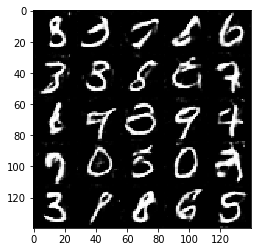

Epoch 2/2... Discriminator Loss: 1.1473... Generator Loss: 2.0998
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 1.0401
Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 1.4407
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.3714
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.0536
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.1066... Generator Loss: 1.9361
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.2370
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.4611


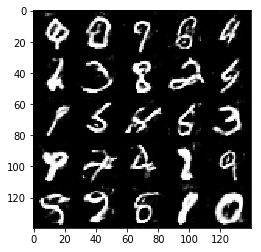

Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.9831
Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 1.7437
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 1.3562
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 1.1608
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 1.3043
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 1.6855
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.9473
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 0.9520


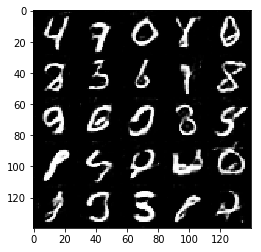

Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 1.2407
Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 2.4625
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 1.2633
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.2956
Epoch 2/2... Discriminator Loss: 2.0227... Generator Loss: 0.3679
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 2.0164


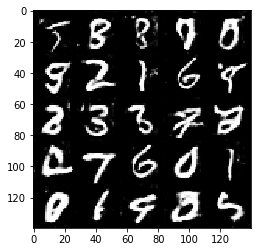

Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 1.3184
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 1.7896
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 1.0290
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 1.4140
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 1.4198
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.4928
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.5183


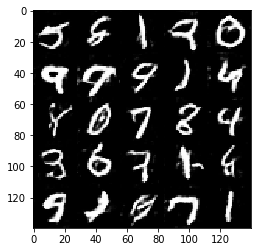

Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.1613
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 1.2363
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 1.4222


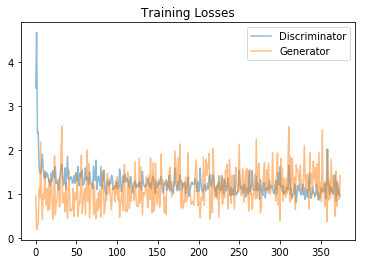

In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 9.2741... Generator Loss: 21.7778
Epoch 1/1... Discriminator Loss: 2.8875... Generator Loss: 0.2837
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 3.2631
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 2.3584
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 2.5857
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 4.1546
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.0051


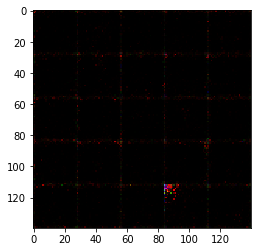

Epoch 1/1... Discriminator Loss: 4.5842... Generator Loss: 5.3152
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.3218
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 2.3088
Epoch 1/1... Discriminator Loss: 5.7220... Generator Loss: 6.3604
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7132


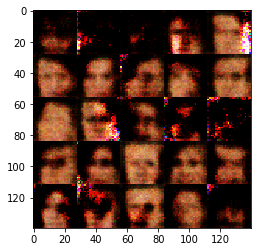

Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 2.0100... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.9401... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 2.0410
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 2.7072
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 2.4351
Epoch 1/1... Discriminator Loss: 2.3406... Generator Loss: 2.2360


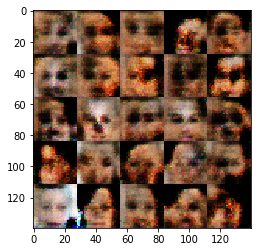

Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.8809... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7264


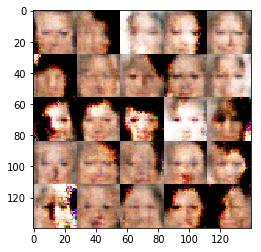

Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 2.0963
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.7752... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 1.9173
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.6456
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 1.9837
Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 3.2829... Generator Loss: 3.1081


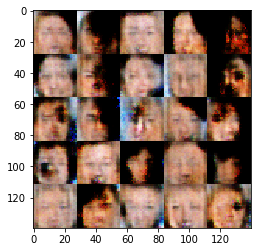

Epoch 1/1... Discriminator Loss: 2.3602... Generator Loss: 0.2460
Epoch 1/1... Discriminator Loss: 2.0761... Generator Loss: 0.2805
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 1.6682
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.8546


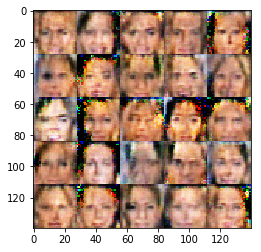

Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.9798... Generator Loss: 0.2817
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.9816... Generator Loss: 0.2755
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 1.5691


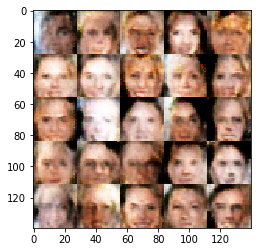

Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 1.4948
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 1.8734
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.5282


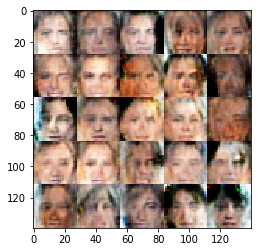

Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.8448


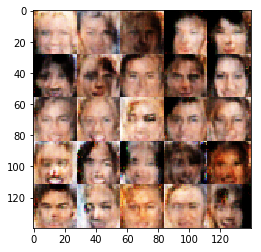

Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.7686... Generator Loss: 0.3617
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 1.0440


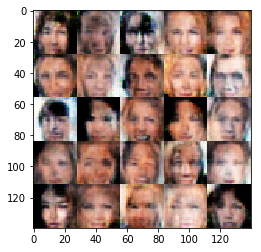

Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.7501... Generator Loss: 0.7409


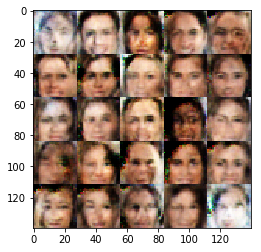

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 1.0016


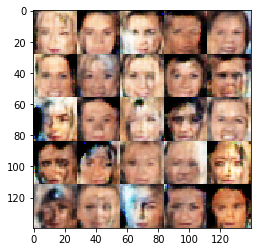

Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8692


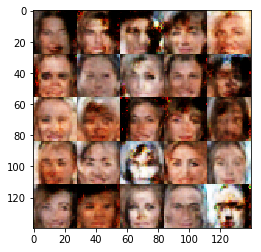

Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8096


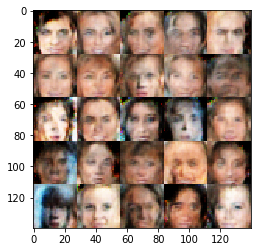

Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.9304


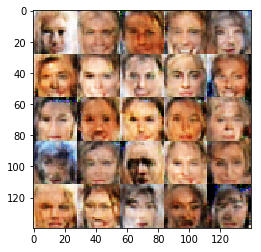

Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 1.0350


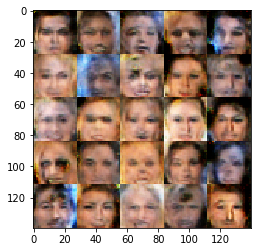

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6403


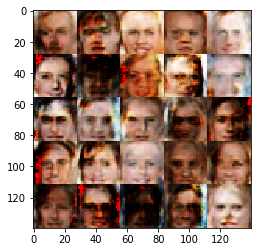

Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6542


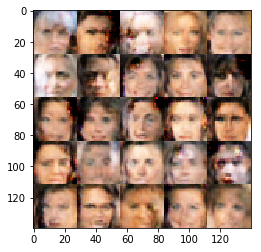

Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8789


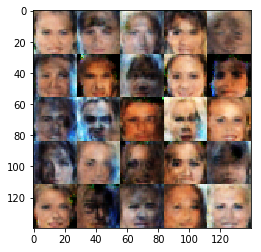

Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.4347
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.5969


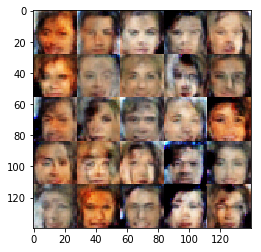

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.9184


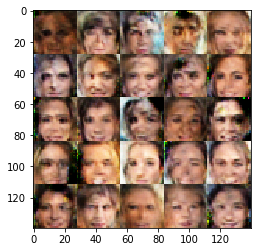

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9590


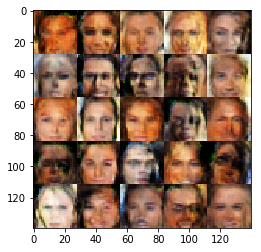

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.8334... Generator Loss: 0.3523
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.8623


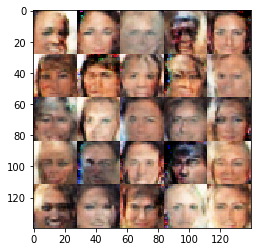

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.7187


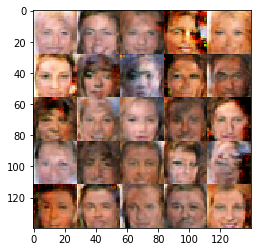

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8066


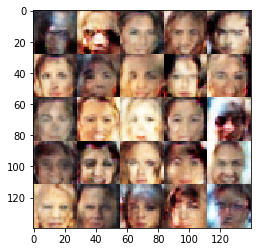

Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8236


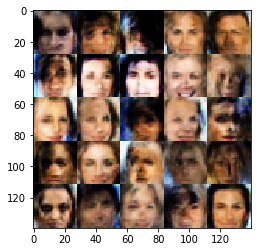

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.8656


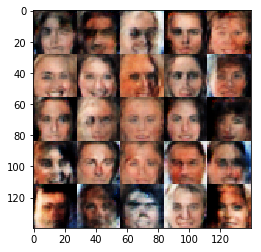

Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8513


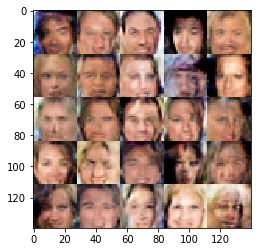

Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7998


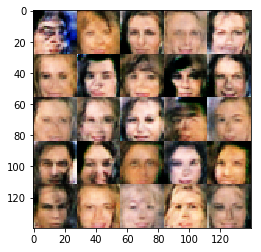

Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8778


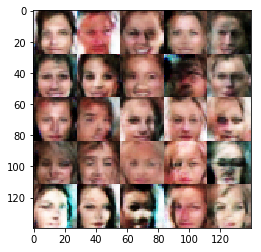

Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8236


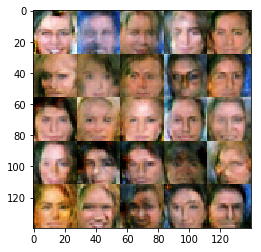

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8585


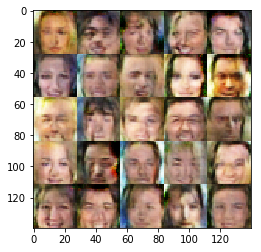

Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8302


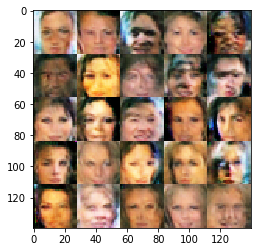

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0763


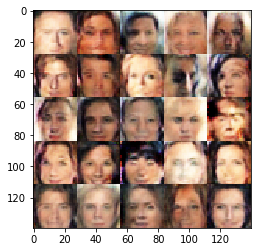

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6298


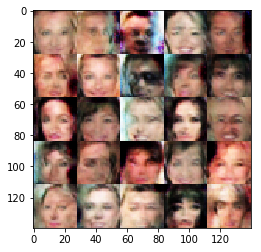

Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8093


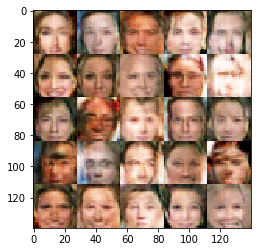

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.8560


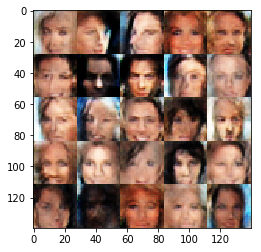

Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7900


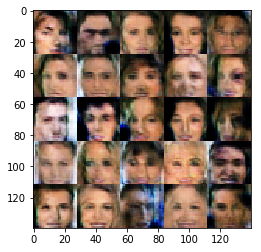

Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 1.1743


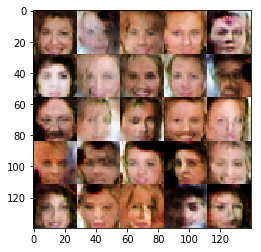

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7545


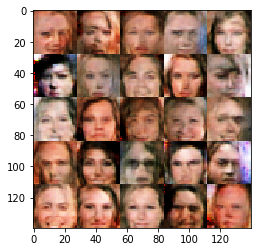

Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8278


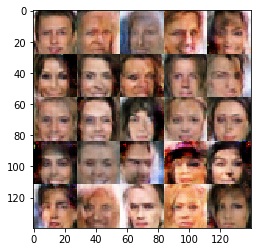

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.8236


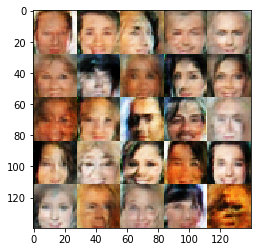

Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8257


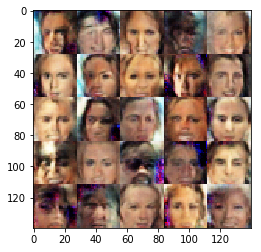

Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.9929


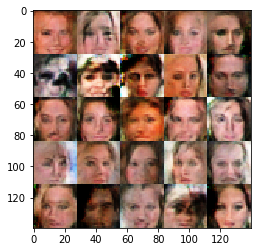

Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.7611


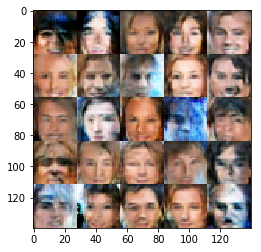

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7600


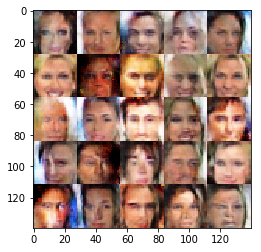

Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6924


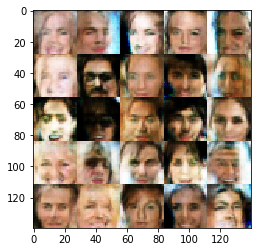

Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.9659


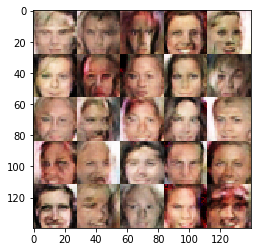

Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.7361


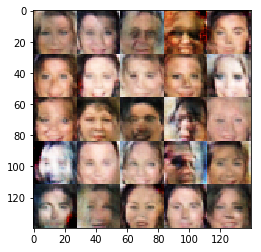

Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8242


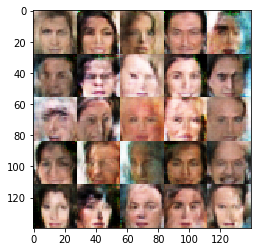

Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8843


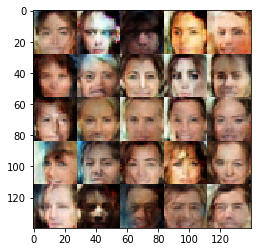

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9724


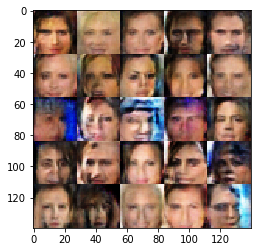

Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8264


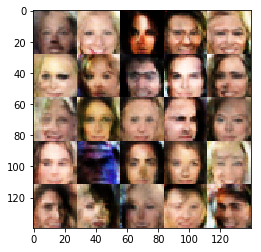

Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8972


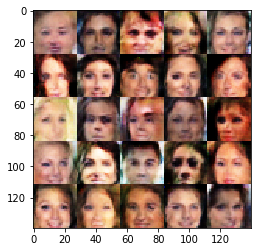

Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7972


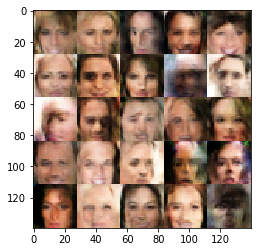

Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8244


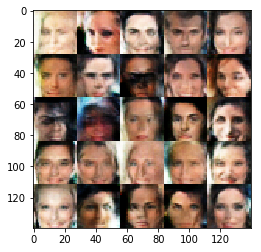

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7417


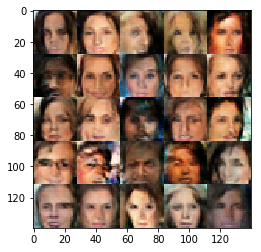

Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.8751


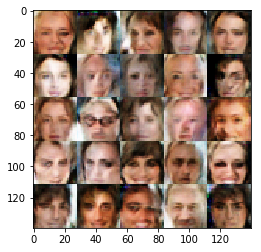

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.8405


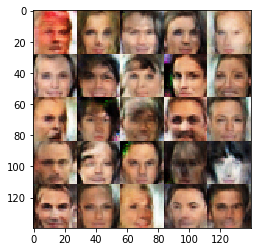

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.8300


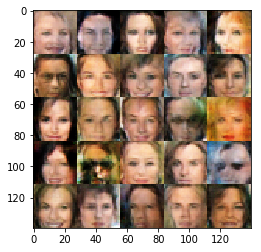

Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8220


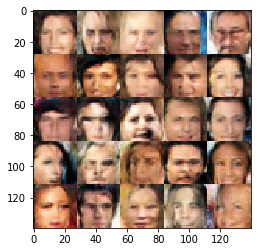

Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.9129


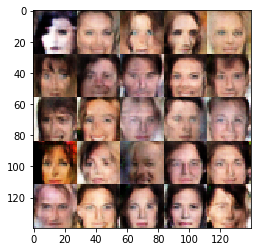

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8480


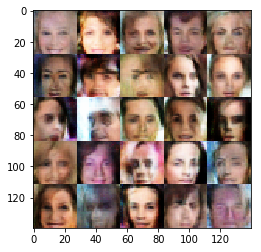

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8276


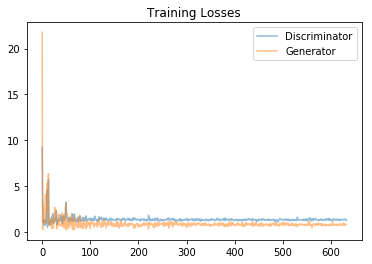

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.